In [1]:
# pip install gymnasium
# pip install torch

import pandas as pd
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

# 2. First steps

We will start by gaining intuition on the task at hand by running a random agent. Create a
RandomAgent, which selects actions randomly. 

In [2]:
class RandomAgent:
        
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transistion of the environment"""
        pass
    
    def select_action(self, state):
        """"Pick an action from the given state"""
        return env.action_space.sample()
    
    def update(self):
        """"Called after each environment step. 
        This is where all the training takes place"""
        pass

Run the agent on the environment until the episode is
either truncated or terminated. Store the episode and render (visualize) it.

In [3]:
env = gym.make('MountainCar-v0', render_mode='human')

agent = RandomAgent()

done = False
state, _ = env.reset()
episode_reward = 0

states = []
actions = []
rewards = []

while not done:
    env.render()
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += float(reward)
    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = next_state
    done = terminated or truncated

env.close() 

Now run the agent for 100 episodes. At every episode initialize the environment with a new randomly
sampled seed. Plot the duration of each episode as a scatter plot. What do you find? Explain.

In [4]:
env = gym.make('MountainCar-v0')

agent = RandomAgent()
episode_durations = []
n_episodes = 100
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_length = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        state = next_state
        episode_length += 1
        done = terminated or truncated

    episode_durations.append(episode_length)

100%|██████████| 100/100 [00:00<00:00, 350.03it/s]


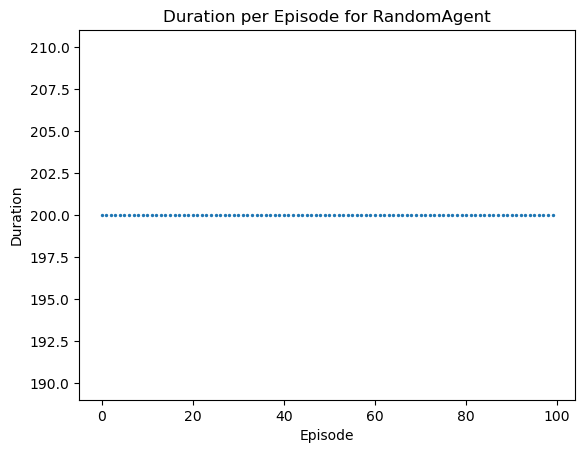

In [8]:
plt.scatter(range(n_episodes), episode_durations, s=2)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Duration per Episode for RandomAgent')
plt.show()

We find that by taking random actions, the car is never lucky and cannot finish even a single episode. 

# 3. DQN

## 3.1 and 3.2 Implementation and No auxiliary reward
Create a `DQNAgent` class that implements a DQN agent that uses a feed-forward network to estimate
Q-values and an eps-greedy policy to take actions. Since DQN is an off-policy RL algorithm, make sure
your class has a replay buffer that allows to add observed transitions `(s,a,r,s′)` and sample batches of
transitions for the network updates

In [12]:
class DQNAgent:

    def __init__(self, env):
        self.env = env
        self.Q = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
        self.gamma = 0.99
        self.t = 0
        self.epsilon = 0.9
        self.replay_buffer = deque(maxlen=10000) # list-like container with fast appends and pops on either end
        self.batch_size = 64
        self.optimizer = torch.optim.Adam(
            self.Q.parameters(),
            lr = 0.001
        )
    
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transition of the environment"""
        self.replay_buffer.append((state, action, next_state, reward))
    
    def select_action(self, state):
        """" Pick an action from the given state """
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # convert to tensor + add batch dimension
        Q_values = self.Q(state_tensor)
        action = self.epsilon_greedy(Q_values)
        return action  
    
    def update(self): 
        if len(self.replay_buffer) < self.batch_size:
            return 0 # Not enough samples
        
        transitions_minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, next_states, rewards = zip(*transitions_minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)

        current_qs = self.Q(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_qs = self.Q(next_states).max(1)[0].detach()
        targets = rewards + self.gamma * next_qs

        loss = F.mse_loss(current_qs, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    def epsilon_greedy(self, Q_val):
        """ Chooses an epsilon-greedy action starting from a given state and given Q-values """
        
        if self.epsilon > 0.05:
            self.epsilon = 0.9 * np.exp(-0.0017 * self.t)
        self.t += 1 

        if np.random.uniform(0, 1) < self.epsilon:
            # random move (exploration)
            return self.env.action_space.sample()
        else:
            # with probability 1-epsilon choose the action with the highest immediate reward (exploitation)
            return torch.argmax(Q_val).item() # tensor to int

Train the DQNAgent for 1000 episodes and report its loss and average cumulative reward per episode.
Does your agent solve the task?

In [13]:
env = gym.make('MountainCar-v0')

agent_DQN = DQNAgent(env)
episode_durations = []
episode_rewards = []
episode_losses = []
n_episodes = 1000
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_reward = 0
    episode_length = 0
    episode_loss = 0
    
    while not done:
        action = agent_DQN.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent_DQN.observe(state, action, next_state, reward)

        loss = agent_DQN.update()
        state = next_state
        episode_length += 1
        episode_loss += loss 
        episode_reward += float(reward)
        done = terminated or truncated

    episode_durations.append(episode_length)
    episode_rewards.append(episode_reward)
    episode_losses.append(episode_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\helli\AppData\Local\Temp\ipykernel_12552\3942693024.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  states = torch.tensor(states, dtype=torch.float32)
100%|██████████| 1000/1000 [08:04<00:00,  2.06it/s]


In [19]:
print(f"The average cumulative reward per episode is {sum(episode_rewards)/n_episodes}")

The average cumulative reward per episode is -200.0


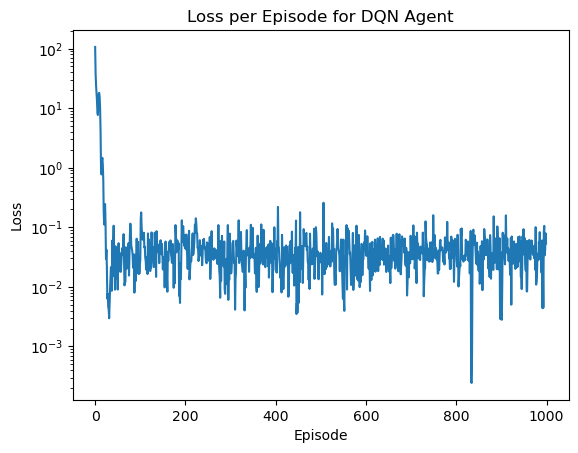

In [18]:
episode_losses_array = [x.detach().numpy() for x in episode_losses]
plt.plot(range(n_episodes), episode_losses_array)
plt.yscale("log")
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss per Episode for DQN Agent')
plt.show()

In [21]:
env = gym.make('MountainCar-v0', render_mode='human')

done = False
state, _ = env.reset()

while not done:
    env.render()
    action = agent_DQN.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    # agent_DQN.observe(state, action, next_state, reward)

    # agent_DQN.update()
    state = next_state
    done = terminated or truncated

env.close() 

No, the agent does not solve the task. However, we see that the actions are not random anymore: the agent mostly want to accelerate to the right. 

## 3.3 Heuristic reward function

In [26]:
def heuristic_reward(next_state, terminated, episode_length): 
    if terminated: 
        return 1+2*(200-episode_length)/200 # favorize short episode 
    aux_reward = np.power(next_state[0]- (-0.5), 2) * 0.1
    return aux_reward

In [27]:
env = gym.make('MountainCar-v0')

agent_DQN_with_AR = DQNAgent(env)
episode_durations = []
episode_rewards = []
episode_aux_rewards = []
episode_losses = []
success_track = []
n_episodes = 1500 # 3000
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_reward = 0
    episode_aux_reward = 0
    episode_length = 0
    episode_loss = 0
    
    while not done:
        action = agent_DQN_with_AR.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        aux_reward = heuristic_reward(next_state, terminated, episode_length)
        agent_DQN_with_AR.observe(state, action, next_state, float(reward) + aux_reward)

        loss = agent_DQN_with_AR.update()
        state = next_state
        episode_length += 1
        episode_loss += loss 
        episode_reward += float(reward)
        episode_aux_reward += aux_reward

        done = terminated or truncated

    success_track.append(1 if terminated else 0)
    episode_durations.append(episode_length)
    episode_rewards.append(episode_reward)
    episode_aux_rewards.append(episode_aux_reward)
    episode_losses.append(episode_loss)

episode_tot_rewards = [x + y for x, y in zip(episode_rewards, episode_aux_rewards)] 

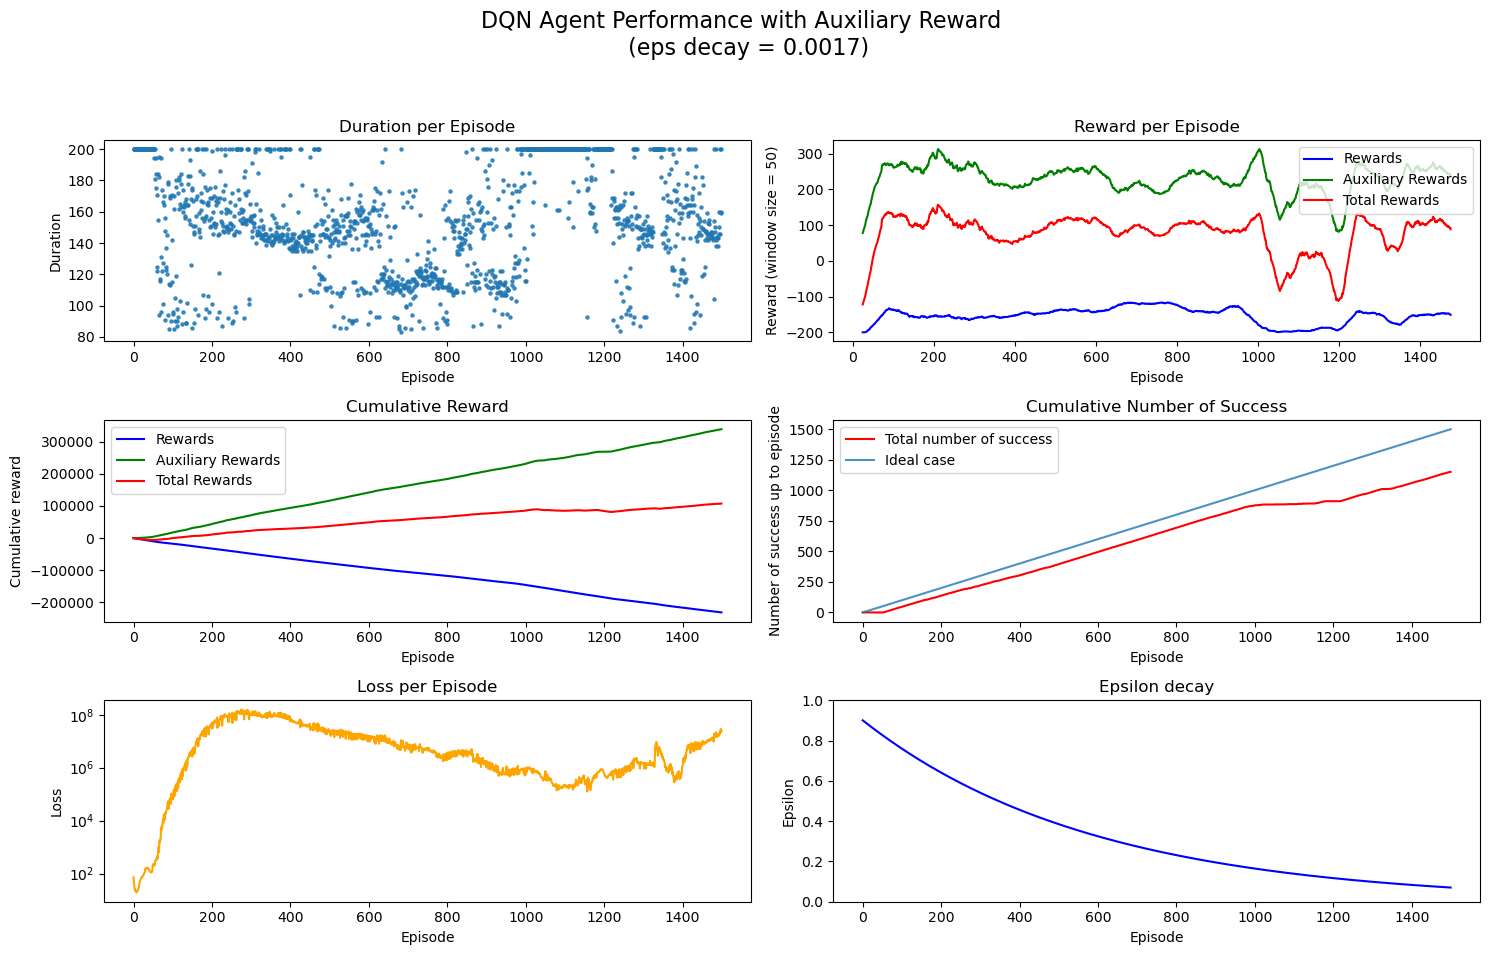

In [25]:
def avg_list(lst):
    list_serie = pd.Series(lst)
    return list_serie.rolling(window=50, center=True).mean()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))  # Adjust the figure size as needed

# Episode duration
axes[0, 0].scatter(range(n_episodes), episode_durations, alpha=0.8, s=5)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Duration')
axes[0, 0].set_title('Duration per Episode')

# Reward
axes[0, 1].plot(avg_list(episode_rewards), color='blue', label='Rewards')
axes[0, 1].plot(avg_list(episode_aux_rewards), color='green', label='Auxiliary Rewards')
axes[0, 1].plot(avg_list(episode_tot_rewards), color='red', label='Total Rewards')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Reward (window size = 50)')
axes[0, 1].set_title('Reward per Episode')
axes[0, 1].legend()

# Cumulative reward
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_rewards), color='blue', label='Rewards')
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_aux_rewards), color='green', label='Auxiliary Rewards')
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_tot_rewards), color='red', label='Total Rewards')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Cumulative reward')
axes[1, 0].set_title('Cumulative Reward')
axes[1, 0].legend()

# Cumulative number of success
axes[1, 1].plot(range(n_episodes), np.cumsum(success_track), color='red', label='Total number of success')
axes[1, 1].plot(range(n_episodes), range(n_episodes), alpha=0.8, label = 'Ideal case')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Number of success up to episode')
axes[1, 1].set_title('Cumulative Number of Success')
axes[1, 1].legend()

# Training loss
episode_losses_array = [x.detach().numpy() for x in episode_losses]
axes[2, 0].plot(range(n_episodes), episode_losses_array, color='orange')
axes[2, 0].set_yscale("log")
axes[2, 0].set_xlabel('Episode')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].set_title('Loss per Episode')

# epsilon decay
eps_decay = [0.9 * np.exp(-0.0017 * x) for x in range(n_episodes)]
axes[2, 1].plot(range(n_episodes), eps_decay, color='blue')
axes[2, 1].set_ylim(0, 1)
axes[2, 1].set_xlabel('Episode')
axes[2, 1].set_ylabel('Epsilon')
axes[2, 1].set_title('Epsilon decay')

fig.suptitle('DQN Agent Performance with Auxiliary Reward \n (eps decay = 0.0017) big rewards', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
plt.show()

In [76]:
env = gym.make('MountainCar-v0', render_mode='human')

done = False
state, _ = env.reset()

while not done:
    env.render()
    action = agent_DQN_with_AR.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    # agent_DQN_with_AR.observe(state, action, next_state, reward)

    # agent_DQN_with_AR.update()
    state = next_state
    done = terminated or truncated

env.close() 

## 3.4 Non domain-specific reward

In [45]:
class RunningStats:
    def __init__(self):
        self.n = 0
        self.mean = 0
        self.run_var = 0

    def update(self, x):
        self.n += 1
        old_mean = self.mean
        self.mean += (x - self.mean) / self.n
        self.run_var += (x - old_mean) * (x - self.mean)

    @property # property is easier to call than class function
    def variance(self):
        return self.run_var / (self.n - 1) if self.n > 1 else 0

    @property
    def std(self):
        return np.sqrt(self.variance)

def RND_reward(next_state, agent, state_stats, sqrd_diff_stats):
    # Normalize the state using running stats
    if state_stats.n > 1:
        state_norm = (next_state - state_stats.mean) / state_stats.std
    else:
        state_norm = next_state  # If no stats available, use state as is
    state_stats.update(next_state)

    state_norm_tensor = torch.tensor(state_norm, dtype=torch.float32)
    target_val = agent.target(state_norm_tensor)
    predicted_val = agent.predictor(state_norm_tensor)

    r = (target_val - predicted_val).pow(2)
    r_scalar = r.item()
    sqrd_diff_stats.update(r_scalar)  # Update running stats for squared differences 

    if sqrd_diff_stats.n > 1:
        r_norm = (r_scalar - sqrd_diff_stats.mean) / sqrd_diff_stats.std
    else:
        r_norm = r_scalar  # If no variance, use raw squared difference

    r_norm_clip = np.clip(r_norm, -5, 5)
    return r_norm_clip

In [46]:
class DQNAgent_rnd:

    def __init__(self, env):
        self.env = env
        self.Q = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
        self.gamma = 0.99
        self.t = 0
        self.epsilon = 0.9
        self.replay_buffer = deque(maxlen=10000) 
        self.batch_size = 64
        self.Q_optimizer = torch.optim.Adam(
            self.Q.parameters(),
            lr = 0.001
        )
        self.predictor = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        self.target = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        self.predictor_optimizer = torch.optim.Adam(
            self.predictor.parameters(),
            lr = 0.001
        )
    
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transition of the environment"""
        self.replay_buffer.append((state, action, next_state, reward))
    
    def select_action(self, state):
        """" Pick an action from the given state """
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  
        Q_values = self.Q(state_tensor)
        action = self.epsilon_greedy(Q_values)
        return action  
    
    def update(self): 
        if len(self.replay_buffer) < self.batch_size:
            return (0, 0) # Not enough samples
        
        transitions_minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, next_states, rewards = zip(*transitions_minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)

        loss_predictor = self.update_predictor(next_states)

        current_qs = self.Q(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_qs = self.Q(next_states).max(1)[0].detach()
        targets = rewards + self.gamma * next_qs

        loss = F.mse_loss(current_qs, targets)
        self.Q_optimizer.zero_grad()
        loss.backward()
        self.Q_optimizer.step()
        return loss, loss_predictor
    
    def update_predictor(self, next_states):

        target_val = self.target(next_states)
        predicted_val = self.predictor(next_states)

        loss_predictor = F.mse_loss(target_val, predicted_val)
        self.predictor_optimizer.zero_grad()
        loss_predictor.backward()
        self.predictor_optimizer.step()

        return loss_predictor

    def epsilon_greedy(self, Q_val):
        """ Chooses an epsilon-greedy action starting from a given state and given Q-values """
        if self.epsilon > 0.05:
            self.epsilon = 0.9 * np.exp(-0.0017 * self.t)
        self.t += 1 
        if np.random.uniform(0, 1) < self.epsilon:
            # random move (exploration)
            return self.env.action_space.sample() 
        else:
            # with probability 1-epsilon choose the action with the highest immediate reward (exploitation)
            return torch.argmax(Q_val).item()

In [61]:
env = gym.make('MountainCar-v0')

agent_DQN_with_RND = DQNAgent_rnd(env)
state_stats = RunningStats()        # Instantiate and update stats
sqrd_diff_stats = RunningStats()
n_episodes =  3000
reward_factor = 0.5

episode_durations = []
episode_rewards = []
episode_rnd_rewards = []
episode_losses = []
success_track = []

for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_reward = 0
    episode_rnd_reward = 0
    episode_length = 0
    episode_loss = 0
    
    while not done:
        action = agent_DQN_with_RND.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        rnd_reward = RND_reward(next_state, agent_DQN_with_RND, state_stats, sqrd_diff_stats)
        agent_DQN_with_RND.observe(state, action, next_state, reward + reward_factor * rnd_reward)

        Q_loss, predictor_loss = agent_DQN_with_RND.update()
        state = next_state
        episode_length += 1
        episode_loss += Q_loss 
        episode_reward += float(reward)
        episode_rnd_reward += rnd_reward

        done = terminated or truncated

    success_track.append(1 if terminated else 0)
    episode_durations.append(episode_length)
    episode_rewards.append(episode_reward)
    episode_rnd_rewards.append(episode_rnd_reward)
    episode_losses.append(episode_loss)

episode_tot_rewards = [x + y for x, y in zip(episode_rewards, episode_rnd_rewards)]

100%|██████████| 3000/3000 [30:27<00:00,  1.64it/s]


In [64]:
env = gym.make('MountainCar-v0', render_mode='human')

done = False
state, _ = env.reset()

while not done:
    env.render()
    action = agent_DQN_with_AR.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    # agent_DQN_with_RND.observe(state, action, next_state, reward)

    # agent_DQN_with_RND.update()
    state = next_state
    done = terminated or truncated

env.close() 

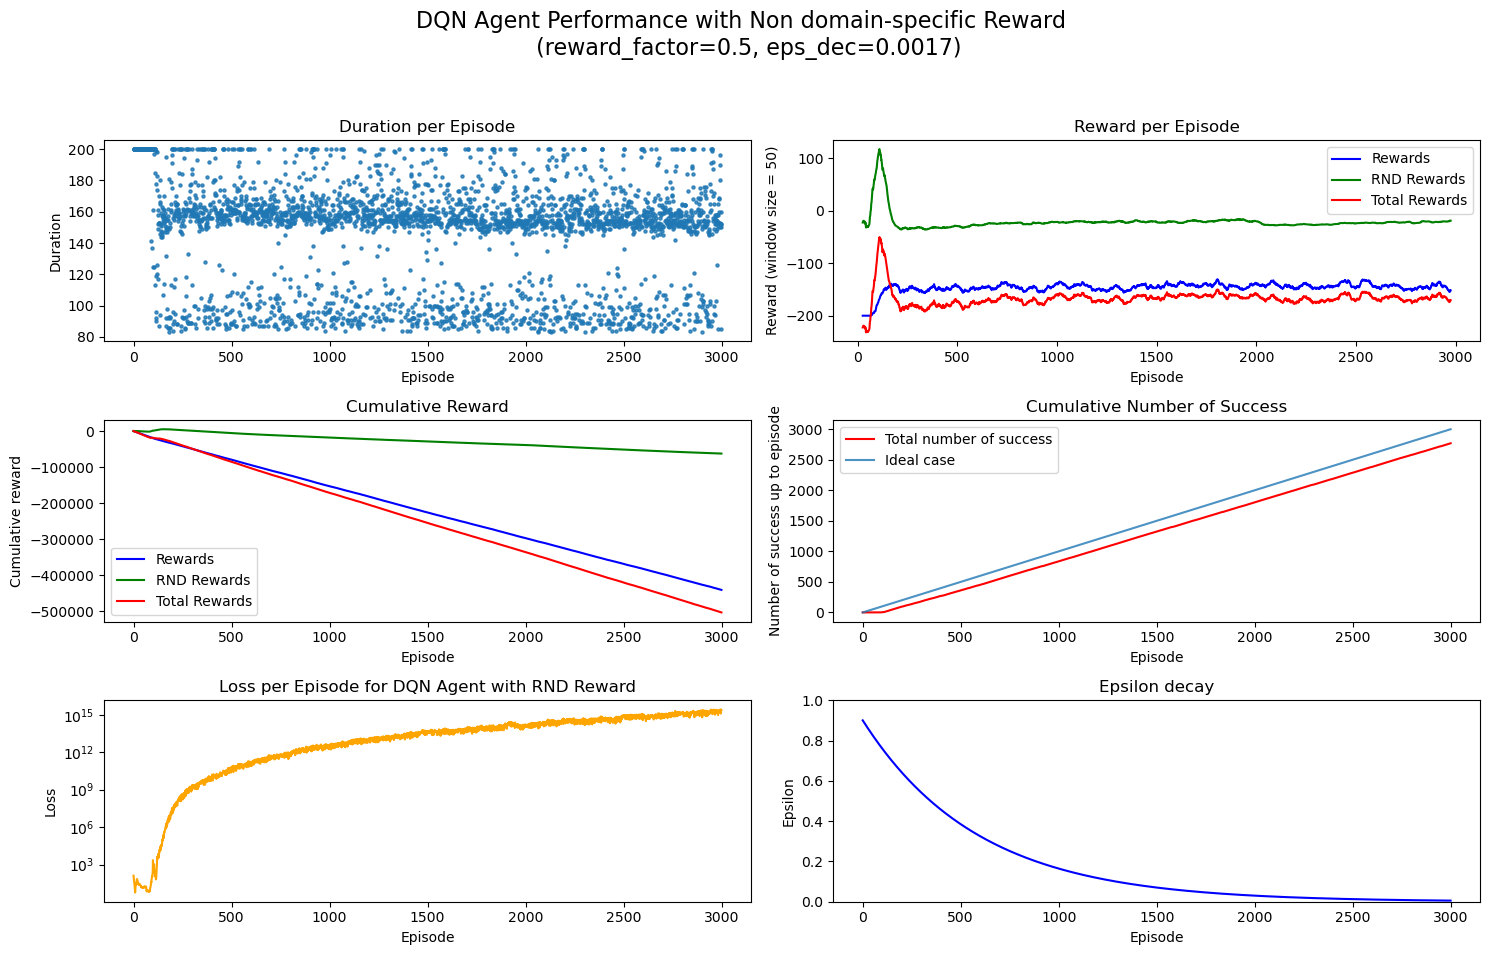

In [63]:
def avg_list(lst):
    list_serie = pd.Series(lst)
    return list_serie.rolling(window=50, center=True).mean()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))  # Adjust the figure size as needed

# Episode duration
axes[0, 0].scatter(range(n_episodes), episode_durations, alpha=0.8, s=5)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Duration')
axes[0, 0].set_title('Duration per Episode')

# Reward
axes[0, 1].plot(avg_list(episode_rewards), color='blue', label='Rewards')
axes[0, 1].plot(avg_list(episode_rnd_rewards), color='green', label='RND Rewards')
axes[0, 1].plot(avg_list(episode_tot_rewards), color='red', label='Total Rewards')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Reward (window size = 50)')
axes[0, 1].set_title('Reward per Episode')
axes[0, 1].legend()

# Cumulative reward
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_rewards), color='blue', label='Rewards')
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_rnd_rewards), color='green', label='RND Rewards')
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_tot_rewards), color='red', label='Total Rewards')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Cumulative reward')
axes[1, 0].set_title('Cumulative Reward')
axes[1, 0].legend()

# Cumulative number of success
axes[1, 1].plot(range(n_episodes), np.cumsum(success_track), color='red', label='Total number of success')
axes[1, 1].plot(range(n_episodes), range(n_episodes), alpha=0.8, label = 'Ideal case')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Number of success up to episode')
axes[1, 1].set_title('Cumulative Number of Success')
axes[1, 1].legend()

# Training loss
episode_losses_array = [x.detach().numpy() for x in episode_losses]
axes[2, 0].plot(range(n_episodes), episode_losses_array, color='orange')
axes[2, 0].set_yscale("log")
axes[2, 0].set_xlabel('Episode')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].set_title('Loss per Episode for DQN Agent with RND Reward')

# epsilon decay
eps_decay = [0.9 * np.exp(-0.0017 * x) for x in range(n_episodes)]
axes[2, 1].plot(range(n_episodes), eps_decay, color='blue')
axes[2, 1].set_ylim(0, 1)
axes[2, 1].set_xlabel('Episode')
axes[2, 1].set_ylabel('Epsilon')
axes[2, 1].set_title('Epsilon decay')

fig.suptitle('DQN Agent Performance with Non domain-specific Reward \n (reward_factor=0.5, eps_dec=0.0017)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
plt.show()

## Additional stuff

In [ ]:
# def heuristic_reward(next_state, reward, terminated): # v1
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 0 
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) # + np.abs(next_state[1]) # + next_state[1] # + np.max(0, next_state[1])
#     return aux_reward

# def heuristic_reward(next_state, reward, terminated): # v2
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 1
#     # if truncated: # -1 if truncated and does not had goal? : peur de niquer nos efforts
#     #     return -1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + np.abs(next_state[1]) # avantage les vitesses positives
    # return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v3
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 1
#     aux_reward = np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1]) # avantage les vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v4
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[0]) + max(0, next_state[1]) # avantage les positions et vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v5
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated and episode_length<110: 
#         return 4
#     if terminated: 
#         return 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1]) # avantage les positions et vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v6
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + abs(next_state[1]) # avantage les positions et vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v7
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     if next_state[0]<-1 or next_state[0]>0.3: 
#         return 1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1])  # avantage les vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v8
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     if next_state[0]<-1.1 or next_state[0]>0.4: 
#         return 1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1])  # avantage les vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v9
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated and episode_length<90: 
#         return 2
#     if terminated: 
#         return 1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) 
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v10
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated and episode_length<90: 
#         return 1+2*(200-episode_length)/200 # favorize short episode with factor of 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) 
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v11 => resultat nul...
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 1+2*(200-episode_length)/200 # favorize short episode with factor of 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) - episode_length/200
#     return aux_reward

Num
Observation
Min
Max
Unit

0
position of the car along the x-axis
-1.2
0.6
position (m)

1
velocity of the car
-0.07
0.07
velocity (v)

Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)

The position of the car is assigned a uniform random value in [-0.6 , -0.4]. 

The starting velocity of the car is always assigned to 0.